# Writing WCS info to FF fits files

Goal of this notebook is to write a world coordinate system to an 'FF-file', the FITS file format used by Global Meteor Network.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS, Sip
from astropy.io import fits
from astropy.table import Table
import json

In [2]:
import pyproj

In [3]:
from astropy.time import Time
from astropy.coordinates import AltAz, EarthLocation, FK5
import astropy.units as u

In [4]:
import RMS.ConfigReader as cr

In [5]:
import json

Read the manually selected astrometry calibration stars from the 'platepar' file.

In [6]:
t = Table(names=["x", "y", "ra", "dec"])

with open(
    "RU0001/platepar_cmn2010.cal"
) as platepar:
    my_platepar = json.load(platepar)
    star_list = my_platepar["star_list"]
    for star in star_list:
        t.add_row(star[1:3] + star[4:6])

In [7]:
t

x,y,ra,dec
float64,float64,float64,float64
592.8053569106817,414.4733678594917,342.41936859811,66.1998674347798
657.2550182447939,218.21166068936557,322.165055708522,70.5607206921572
889.3257941666302,248.3954687432386,311.323181316809,61.8423054857646
1044.732186351117,215.97312017795733,303.349924875647,56.5680737323416
755.0006610329021,42.87045005303109,297.044140294351,70.2681026643958
572.9207513625583,22.184918167712986,302.22251415811,77.7115269295082
360.19788632752505,46.20190694324685,343.608342378519,84.3462788804618
388.9906500995946,209.6672648826769,354.835823347857,77.6331008548773
155.18272584623813,554.7979763401077,28.599179237149,63.6700205880048


Read the ra0, dec0 by converting the azimuth and elevation from the platepar file to ra/dec. For this, we need the station location, which is accessible in the config file.

In [8]:
config = cr.loadConfigFromDirectory(".", "RU0001/")

Loading config file: /Users/dijkema/opt/asm/notebooks/RU0001/.config


The station location altitude is w.r.t. the EGM96 geoid. This can be transformed to a height w.r.t. to the WGS84 ellipsoid with pyproj.

In [9]:
def egm96_to_wgs84(lat_deg, lon_deg, height_m):
    trans = pyproj.Transformer.from_crs("EPSG:4979+5773", "EPSG:4979")
    return trans.transform(lat_deg, lon_deg, height_m)

In [10]:
obsloc = EarthLocation.from_geodetic(
    config.longitude, config.latitude, egm96_to_wgs84(config.latitude, config.longitude, config.elevation)[-1]
)

In [11]:
config.longitude, config.latitude, config.elevation

(37.31514, 44.89074, 26.0)

In [12]:
obsloc.geodetic

GeodeticLocation(lon=<Longitude 37.31514 deg>, lat=<Latitude 44.89074 deg>, height=<Quantity 42.03880765 m>)

In [13]:
radec_centre = AltAz(
    location=obsloc,
    obstime=Time(my_platepar["JD"], format="jd"),
    alt=my_platepar["alt_centre"] * u.deg,
    az=my_platepar["az_centre"] * u.deg,
).transform_to(FK5)
ra0 = radec_centre.ra.degree
dec0 = radec_centre.dec.degree
print(ra0, dec0)

350.2695079146745 66.88058956913541


Read the data, and overplot the calibration stars.

In [14]:
fbfits = fits.open("RU0001/FF_RU0001_20190427_210639_501_0363008.fits")

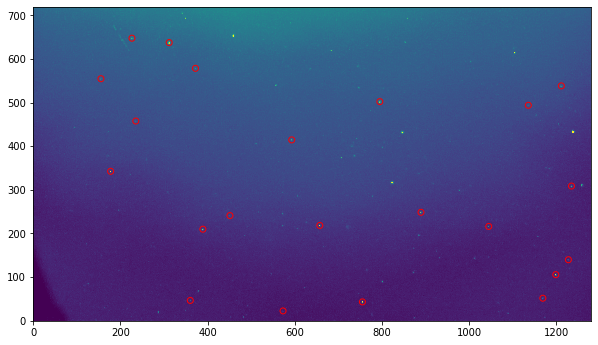

In [15]:
fig, ax0 = plt.subplots(1, figsize=(10, 10))
ax0.imshow(fbfits[1].data, origin="lower")
ax0.scatter(t["x"], t["y"], marker="o", facecolors="None", color="r");

In [16]:
ymax, xmax = fbfits[1].data.shape

In [17]:
x0, y0 = xmax / 2, ymax / 2
dx, dy = t["x"] - x0, t["y"] - y0

Set up a polynomial to fit

In [18]:
order = 3

In [19]:
def solve_linear_equation(a, b):
    q, r = np.linalg.qr(a)
    y = np.dot(q.T, b)
    x = np.linalg.solve(r, y)
    return x

In [20]:
ixs, iys = np.meshgrid(np.arange(order + 1), np.arange(order + 1))
c = ixs + iys <= order
ix, iy = ixs[c], iys[c]

In [21]:
a = np.array([dx ** ix[i] * dy ** iy[i] for i in range(len(iy))]).T

In [22]:
# Iterate to find ra0, dec0 in image center
for k in range(5):
    w = WCS(naxis=2)
    w.wcs.ctype = ["RA---ZEA", "DEC--ZEA"]
    w.wcs.cd = [[1.0, 0.0], [0.0, 1.0]]
    w.wcs.crval = [ra0, dec0]
    w.wcs.crpix = [x0, y0]

    rx, ry = w.wcs_world2pix(t["ra"], t["dec"], 1)

    ax = solve_linear_equation(a, rx)
    ay = solve_linear_equation(a, ry)

    print(ra0, dec0, ax[0], ay[0])

    ra0, dec0 = w.wcs_pix2world(([[ax[0], ay[0]]]), 1)[0]

350.2695079146745 66.88058956913541 634.0980018280876 360.7338531705609
335.0749989396181 66.89044433588424 640.0006214521936 360.0000280987394
335.0765822973831 66.89047242672582 639.9999999338845 360.00000000565865
335.0765821289317 66.89047243238447 640.0000000000074 359.99999999999784
335.0765821289506 66.89047243238231 639.9999999999999 360.0


In [23]:
cd = np.array([[ax[1], ax[order + 1]], [ay[1], ay[order + 1]]])
cdinv = np.linalg.inv(cd)

In [24]:
axm = np.zeros_like(ixs).astype("float32")
aym = np.zeros_like(ixs).astype("float32")
for i in range(len(ix)):
    if ix[i] + iy[i] >= 2:
        p = np.matmul(cdinv, np.array([ax[i], ay[i]]))
        axm[iy[i], ix[i]] = p[0]
        aym[iy[i], ix[i]] = p[1]

Create WCS object with distortions.

In [25]:
w = WCS(naxis=2)
w.wcs.ctype = ["RA---ZEA-SIP", "DEC--ZEA-SIP"]
w.wcs.cd = cd
w.wcs.crval = [ra0, dec0]
w.wcs.crpix = [x0, y0]
w.sip = Sip(axm.T, aym.T, None, None, w.wcs.crpix)

In [26]:
np.matrix(w.sip.a)

matrix([[ 0.00000000e+00,  0.00000000e+00, -1.85447402e-06,
          4.85633478e-10],
        [ 0.00000000e+00, -4.65366247e-06,  6.23279428e-09,
          0.00000000e+00],
        [-1.76269805e-06, -5.35891886e-10,  0.00000000e+00,
          0.00000000e+00],
        [ 6.82745505e-09,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00]])

In [27]:
t["xp"], t["yp"] = w.all_world2pix(np.stack((t["ra"], t["dec"]), axis=-1), 1).T

In [28]:
t["rap"], t["decp"] = w.all_pix2world(np.stack((t["x"], t["y"]), axis=1), 1).T

This shows that forward and backward transforms work.

In [29]:
t

x,y,ra,dec,xp,yp,rap,decp
float64,float64,float64,float64,float64,float64,float64,float64
592.8053569106817,414.4733678594917,342.41936859811,66.1998674347798,592.5771824326273,414.54733640293983,342.3954570315077,66.19739738599338
657.2550182447939,218.21166068936557,322.165055708522,70.5607206921572,657.2618089173282,218.15122259694056,322.1714611788344,70.55936400361111
889.3257941666302,248.3954687432386,311.323181316809,61.8423054857646,889.2860942112909,248.3995942042516,311.32114219813053,61.840946876997926
1044.732186351117,215.97312017795733,303.349924875647,56.5680737323416,1044.8658301855874,215.75640296441998,303.3688886164476,56.569887336356175
755.0006610329021,42.87045005303109,297.044140294351,70.2681026643958,754.9920963302367,42.8823709954824,297.04243110367315,70.26789112024248
572.9207513625583,22.184918167712986,302.22251415811,77.7115269295082,572.9138330257871,22.244438993372615,302.2110311008418,77.71209726663048
360.19788632752505,46.20190694324685,343.608342378519,84.3462788804618,360.1916251327877,46.166388524603306,343.6135492748127,84.34486104067511
388.9906500995946,209.6672648826769,354.835823347857,77.6331008548773,389.18849449816184,209.64143192001774,354.8736886810276,77.63495803846176
155.18272584623813,554.7979763401077,28.599179237149,63.6700205880048,155.0147260061363,554.9305444569977,28.585468135431256,63.67680060327469


Write the WCS to the fits headers (to every header with an image, so the four headers with the maxpixel, mean, etc).

In [30]:
wcshdr = w.to_header(relax=True)

In [31]:
for hdrnum in range(1, 5):
    for key in wcshdr:
        fbfits[hdrnum].header.append((key, wcshdr[key]))

In [32]:
fbfits.writeto(
    "RU0001/FF_RU0001_20190427_210639_501_0363008-wcs.fits", overwrite=True,
)

Plot distortion corrections.

In [33]:
p = np.meshgrid(np.linspace(0, xmax, 16), np.linspace(0, ymax, 16))
x, y = p[0].ravel(), p[1].ravel()

In [34]:
xd, yd = w.sip_pix2foc(x, y, 1)

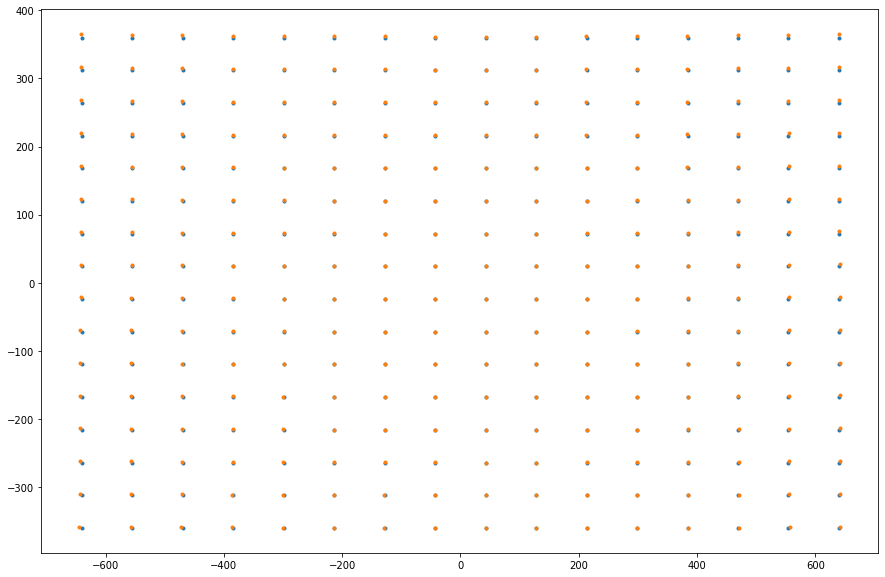

In [35]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(x - x0, y - y0, ".")
ax.plot(xd, yd, ".");